<a href="https://colab.research.google.com/github/claudiohfg/notebooks/blob/main/handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from IPython.display import display
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import warnings

In [ ]:
warnings.simplefilter(action='ignore', category=sk.exceptions.ConvergenceWarning)

# Utility functions

In [ ]:
def eval_model(
    model,
    X: np.array, 
    y: np.array, 
    cv, 
    scoring: str,
    verbose=True) -> np.array:
    score = cross_val_score(
        model,
        X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1)
    
    if verbose:
        score_median = np.abs(np.median(score))
        score_stddev = np.std(score)

        print(f'Median = {score_median} Stddev = {score_stddev}')

        column = str(type(model)).split('.')[-1].split("'")[0]
        pd.DataFrame(score, columns=[column]).plot(
            kind='kde',
            figsize=(10,5),
            xlabel='Predictions',
            ylabel='Score',
            sort_columns=True
        )

        plt.axvline(score_median - 2 * score_stddev, color='yellow', linestyle="--")
        plt.axvline(score_median - score_stddev, color='orange', linestyle="--")
        plt.axvline(score_median, color='red', linestyle="--")
        plt.axvline(score_median + score_stddev, color='orange', linestyle="--")
        plt.axvline(score_median + 2 * score_stddev, color='yellow', linestyle="--")

        plt.show()

    return score

# Loading

In [ ]:
data = load_digits()

Number 8


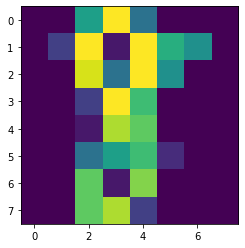

In [ ]:
image_idx = np.random.randint(0, data.images.shape[0])
print(f'Number {data.target[image_idx]}')
plt.imshow(data.images[image_idx])
plt.show()

# Problem description

In [ ]:
print(data['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

# Train eval split

Data will be split into two sets, one for training, the other for validation.

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
    data.data, data.target, test_size=0.2)

# Model selection

These models were previously trained and had their parameters validated using RandomizedSearchCV.

In [ ]:
models = [
    ('LGBMClassifier', LGBMClassifier),
    ('KNeighbors', KNeighborsClassifier),
    ('RandomForest', RandomForestClassifier),
    ('MLPClassifier', MLPClassifier)
]

In [ ]:
params = [
    {
        'boosting_type': ['gbdt', 'dart', 'goss'],
        'num_leaves': [17, 31, 63],
        'learning_rate': [0.1, 1e-2, 1e-3],
        'n_estimators': [100, 150, 200, 250, 300],
    },
    {
        'n_neighbors': [3, 5, 7, 9, 11],
        'leaf_size': [17, 31, 63, 127],
        'weights': ['uniform', 'distance'],
        'n_jobs': [-1]
    },
    {
        'n_estimators': [100, 150, 200, 250, 300],
        'oob_score': [True, False],
        'criterion': ['gini', 'entropy'],
        'n_jobs': [-1],
    },
    {
        'hidden_layer_sizes': [(100,), (100, 100,), (200, 200,), (100, 100, 100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [200, 250, 300],
        'tol': [1e-4, 1e-5],
        'early_stopping': [True, False],
        'n_iter_no_change': [10, 15, 20],
    }
]

In [ ]:
best_params = []
scores = []

for idx in tqdm(range(len(models))):
    name, model = models[idx]
    rscv = RandomizedSearchCV(
        model(),
        params[idx],
        scoring='accuracy',
        n_iter=15,
        cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=0))
    rscv.fit(X_train, y_train)
    best_params.append(rscv.best_params_)
    scores.append(f'Model {name} \t Score {rscv.best_score_}')

print()

for score in scores:
    print(score)

100%|██████████| 4/4 [06:16<00:00, 94.19s/it] 


Model LGBMClassifier 	 Score 0.9714683368128044
Model KNeighbors 	 Score 0.9846903270702853
Model RandomForest 	 Score 0.9714683368128044
Model MLPClassifier 	 Score 0.9714683368128044


In [ ]:
best_models = [(name, model(**params)) for (name, model), params in list(zip(models, best_params))]

Cross validation is used to train and test the model in different sets, providing us a mean and a standard deviation.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

In [ ]:
result = []
scores = dict()

for name, model in tqdm(best_models):
    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1)
    scores[name] = sorted(score.tolist())
    result.append([name, np.abs(np.median(score)), np.std(score)])

100%|██████████| 4/4 [00:40<00:00, 10.04s/it]


In [ ]:
result = pd.DataFrame(result, columns=['Model', 'Median', 'Stddev'])
result.sort_values(
    by=['Median', 'Stddev'],
    ascending=[False, True],
    inplace=True)
result.reset_index(drop=True, inplace=True)
display(result)

selected_model = list(filter(
    lambda x: x[0] == result.iloc[0, 0], best_models))[0][1]

,Model,Median,Stddev
0,KNeighbors,0.986087,0.005031
1,LGBMClassifier,0.980873,0.011263
2,MLPClassifier,0.975610,0.011229
3,RandomForest,0.970383,0.007911


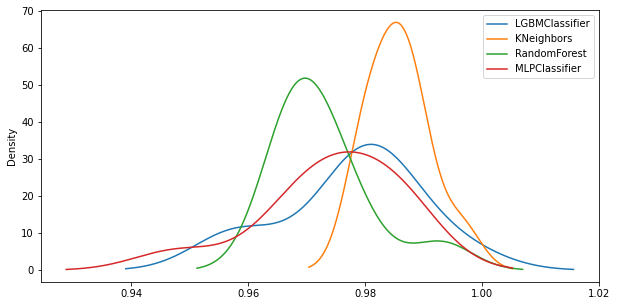

In [ ]:
pd.DataFrame(scores).plot(
    kind='kde',
    figsize=(10,5),
    xlabel='Predictions',
    ylabel='Score',
    sort_columns=True
)
plt.show()

# Validation

Median = 0.987484524914887 Stddev = 0.004664935402659129


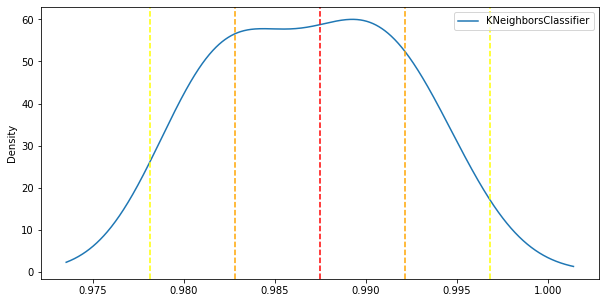

In [ ]:
_ = eval_model(selected_model, data.data, data.target, cv, 'accuracy')

# Voting classifier

In [ ]:
vclf = VotingClassifier(best_models, n_jobs=-1, voting='soft')

Median = 0.987484524914887 Stddev = 0.004737186751131345


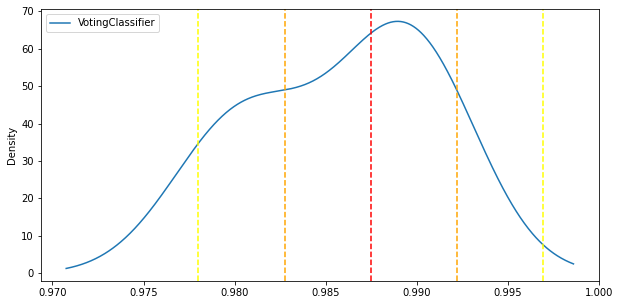

In [ ]:
_ = eval_model(vclf, data.data, data.target, cv, 'accuracy')